# [Project 1] 교통 표지판 이미지 분류

## 프로젝트 목표
- 이미지 데이터를 전처리하는 과정과 딥러닝 모델에 적용하기 위한 형태로 변환하는 과정을 학습
- 교통 표지판 이미지 데이터를 활용하여 CNN 모델로 표지판 종류를 예측하는 분류 모델 학습

## 프로젝트 목차
1. **데이터 확인하기**: 프로젝트에 사용할 데이터셋 디렉토리가 어떤 구조를 가지는지 확인

2. **데이터 분석**: 데이터셋에 포함된 이미지 데이터셋들이 어떤 특징을 가지는지 분석

3. **모델 학습을 위한 데이터셋 구성**: CNN 모델에 학습하기 위해 Tensorflow를 통해 데이터셋을 구성

4. **CNN 모델 학습**: 이미지 처리에 특화된 Convolutional Layer를 활용한 CNN 모델을 학습

## 데이터 출처
-  https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

## 프로젝트 개요

차량 운전자의 기본 소양은 내 차의 주변 상황을 실시간으로 인지하면서 시시각각 변하는 도로 상황 속에서 사고가 나지 않도록 안전하게 운전하는 것일 것입니다. 이 주변 상황을 객관적으로 알려주는 장치에는 **교통 표지판**이 있을 것입니다. 교통 표지판은 앞선 도로의 상황이 어떨 것인지, 해당 도로에서는 어떤 점을 주의해야 하는지 등의 정보를 담고 있기에 초보 운전 때부터 모든 내용을 숙지하고 도로로 나오는 것이 바람직할 것입니다.

<center><img src="img/traffic_sign.jpg"></center>

최근에는 인공지능 기술이 발전함에 따라 사람이 아닌 자동차가 스스로 운전할 수 있게 하는 자율주행 기술이 함께 발전하고 있습니다. 자율주행 기술의 핵심은 역시 자동차에 장착된 카메라가 영상으로 도로 상황을 포착하는 것일 것입니다. 이 영상에는 당연히 교통 표지판도 포함되어 있을 것이므로, **교통 표지판의 내용을 분류**한 다음에 자동차가 적절한 행동을 취하는 과정이 필요할 것입니다.

따라서 이번 프로젝트에서는 교통 표지판이 촬영된 이미지를 통해 교통 표지판이 어떤 내용인지 분류하는 모델을 딥러닝 모델을 통해 간단하게 구현할 것입니다. 이를 위해 이미지 데이터 처리에 특화된 **Convolutional Neural Network(CNN)** 를 활용할 것입니다.

## 1. 데이터 확인하기

In [1]:
# 프로젝트에서 사용할 라이브러리들을 불러옵니다.
import os
import random

# Tensorflow 관련 디버그 및 경고 메시지 비활성화
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw
from tqdm import tqdm


SEED = 2022
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()
np.random.seed(SEED)
random.seed(SEED)

본 프로젝트에서 사용할 데이터셋은 최상단 디렉토리에 아래와 같은 파일 및 디렉토리를 포함하고 있습니다.
- `Train`
- `Train.csv`
- `Test`
- `Test.csv`
- `Meta`
- `Meta.csv`

`Meta` 및 `Meta.csv`의 내용은 본 프로젝트에서는 사용할 필요가 없기 때문에 따로 다루지 않겠습니다.

`Train.csv` 및 `Test.csv`에서는 각각 `Train` 폴더의 이미지와 `Test` 폴더의 이미지들의 메타데이터를 담고 있습니다. 바로 확인해보겠습니다.

In [2]:
root_dir = './data'

train_metadata = pd.read_csv(os.path.join(root_dir, 'Train.csv'))
test_metadata = pd.read_csv(os.path.join(root_dir, 'Test.csv'))

train_metadata.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [3]:
test_metadata.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


두 파일 모두 같은 컬럼을 가지고 있는 것을 확인할 수 있습니다. 각 컬럼의 내용은 다음과 같습니다.

- `Width`: 이미지 파일의 너비
- `Height`: 이미지 파일의 높이
- `Roi.X1`: 이미지 파일 내에서 실제 표지판이 존재하는 곳을 상자로 감쌌을 때 좌상단 X좌표
- `Roi.Y1`: 이미지 파일 내에서 실제 표지판이 존재하는 곳을 상자로 감쌌을 때 좌상단 Y좌표
- `Roi.X2`: 이미지 파일 내에서 실제 표지판이 존재하는 곳을 상자로 감쌌을 때 우하단 X좌표
- `Roi.Y2`: 이미지 파일 내에서 실제 표지판이 존재하는 곳을 상자로 감쌌을 때 우하단 Y좌표
- `ClassId`: 해당 이미지의 클래스 ID (0 ~ 42까지 존재)
- `Path`: 실제 이미지가 저장된 경로

`Roi` 컬럼의 내용은 이미지로 직접 확인해보면 아래와 같습니다. (참고로 RoI는 Region of Interest라는 뜻입니다)

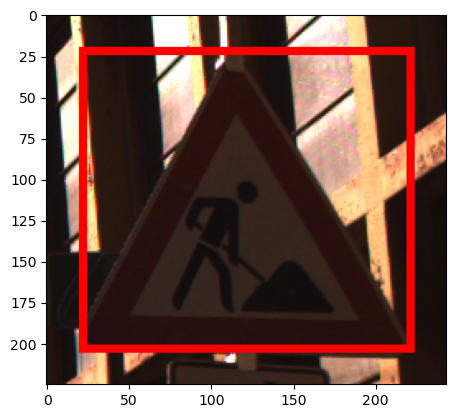

In [9]:
sample_metadata = train_metadata.iloc[28589, :]
sample_img = Image.open(os.path.join(root_dir, sample_metadata['Path']))

roi_box = ImageDraw.Draw(sample_img)
roi_box.rectangle(
    (
        sample_metadata['Roi.X1'], # 좌상단 X 좌표
        sample_metadata['Roi.Y1'], # 좌상단 Y 좌표
        sample_metadata['Roi.X2'], # 우하단 X 좌표
        sample_metadata['Roi.Y2'], # 우하단 Y 좌표
    ),
    outline=(255, 0, 0), # Bounding Box 색을 빨간색으로
    width=5 # Bounding Box 선의 두께
)

plt.imshow(sample_img)

설명한 대로 표지판을 감싸는 Bounding Box를 그리는 것을 확인할 수 있습니다.

이 정보는 본 프로젝트의 목적인 이미지 **분류**에는 크게 필요하지 않지만, **객체 인식(Object Detection)** 작업을 할 때는 필수적인 정보입니다.

하지만 본 프로젝트에서는 이 RoI 정보를 추후 제출시에 사용할 것입니다. 자세한 내용은 그쪽에서 다루겠습니다.

## 2. 데이터 분석

이제 CSV로 저장된 메타데이터를 통해 전체 데이터셋에 있는 이미지 파일들이 어떤 특징을 가지는지 확인해보겠습니다.

먼저 앞서 메타데이터를 확인해본 결과 각 이미지 파일의 너비와 높이가 모두 다른 것처럼 보였는데, 좀 더 확인해보겠습니다.

In [10]:
train_metadata.head(n=20)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
5,31,27,6,5,26,22,20,Train/20/00020_00000_00005.png
6,31,28,6,6,26,23,20,Train/20/00020_00000_00006.png
7,31,28,6,6,26,23,20,Train/20/00020_00000_00007.png
8,31,29,5,6,26,24,20,Train/20/00020_00000_00008.png
9,34,32,6,6,29,26,20,Train/20/00020_00000_00009.png


역시 모두 같은 크기가 아님을 알 수 있습니다. 딥러닝 모델에 적용하기 위해서는 모두 같은 크기의 이미지를 가져야 하기 때문에 하나의 값으로 통일하는 것이 좋습니다.

그러기 위해 먼저 학습 데이터에서 이미지 너비(Width)와 높이(Height)의 분포를 살펴보겠습니다.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


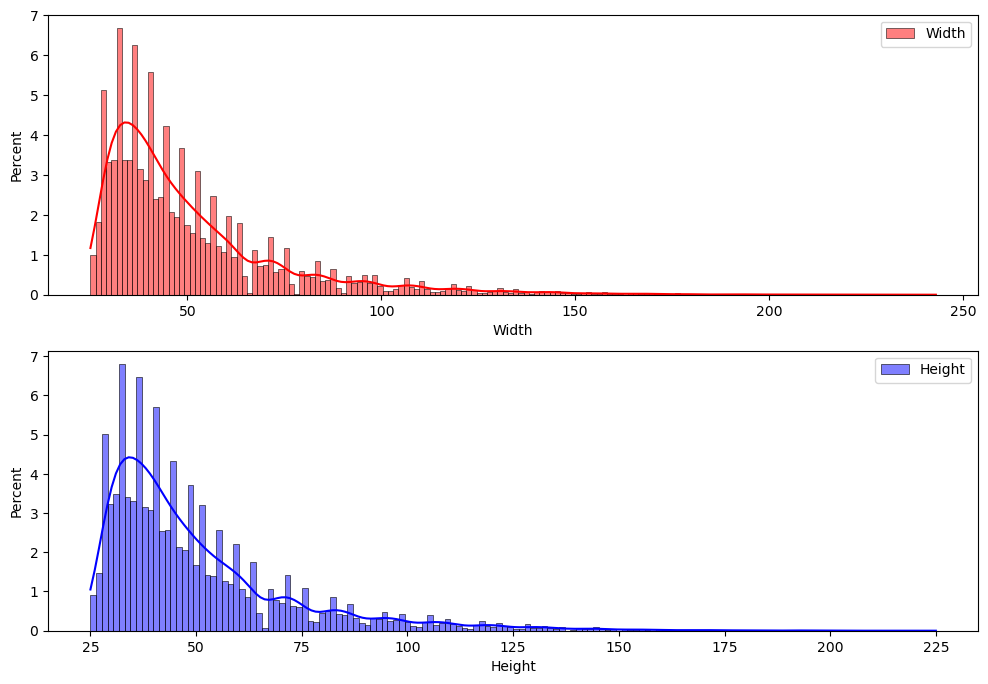

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sns.set_palette('tab10')
sns.histplot(train_metadata, x='Width', kde=True, stat='percent', label='Width', ax=ax[0], color='r')
ax[0].legend()
sns.histplot(train_metadata, x='Height', kde=True, stat='percent', label='Height', ax=ax[1], color='b')
ax[1].legend()

In [12]:
print(
    f"[너비] 평균: {train_metadata['Width'].mean()}\n"
    f"[너비] 중간값(median): {train_metadata['Width'].median()}\n"
    f"[너비] 표준편차: {train_metadata['Width'].std(ddof=0)}"
)
print("=" * 50)
print(
    f"[높이] 평균: {train_metadata['Height'].mean()}\n"
    f"[높이] 중간값(median): {train_metadata['Height'].median()}\n"
    f"[높이] 표준편차: {train_metadata['Height'].std(ddof=0)}"
)

[너비] 평균: 50.83587951745773
[너비] 중간값(median): 43.0
[너비] 표준편차: 24.30662313019734
[높이] 평균: 50.328929582493814
[높이] 중간값(median): 43.0
[높이] 표준편차: 23.115127795107913


대부분의 이미지 파일의 너비와 높이는 50 이하인 것으로 확인됩니다. 실제로도 중간값은 50보다 작은 값에 위치하기도 합니다.

이미지 크기를 하나로 통일하기 위해서 어느 정도 절충안이 필요해 보이는데, 이 때는 보통 유명한 모델이나 데이터셋이 사용하는 값을 사용하는 것이 일반적입니다.

당연히 절대적인 것은 아니라서 "내가 구성한 모델에서는 내가 정한 사이즈가 좋았다"라고 하면 다른 값을 사용해도 되지만, 이 프로젝트는 일단 그런 거창한 모델을 만드는 것은 아니므로 유명 데이터셋이 사용하는 값을 가져오겠습니다.

우리가 참고할 데이터셋은 [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)입니다. 이 데이터셋은 이미지 분류 모델의 성능을 평가하기 위한 대표적인 벤치마크 데이터셋이며, 대부분의 비전 모델 논문들이 본인들의 성능을 주장하기 위해 사용하는 데이터셋 중 하나입니다.

이 데이터셋은 모든 이미지가 32 $\times$ 32의 크기를 가지는 컬러 이미지입니다. 따라서 본 프로젝트에서도 모든 이미지의 사이즈를 32 $\times$ 32로 통일시키도록 하겠습니다. 

In [13]:
img_height, img_width = 32, 32

## 3. 모델 학습을 위한 데이터셋 구성

이제 Tensorflow를 활용하여 모델 학습을 위한 학습 데이터셋과 테스트 데이터셋을 구성하도록 하겠습니다.

먼저 학습 데이터셋은 `Train` 디렉토리에 존재하며, 각 이미지는 클래스 ID 별 디렉토리에 나눠져서 저장되어 있습니다.

<center><img src="img/train_dir.png"></center>

이렇게 클래스 ID 별로 디렉토리가 나눠진 경우, Tensorflow에서는 [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)를 활용하면 데이터셋을 손쉽게 생성할 수 있습니다.

구체적인 사용 방법은 먼저 `ImageDataGenerator` 객체를 생성한 후, 이 객체의 `flow_from_directory` 메소드를 통해 데이터셋을 생성하는 것입니다.

클래스와 메소드의 의미를 좀더 부연하자면 `ImageDataGenerator`란 이름에서 알 수 있듯이 이미지 데이터를 **생성(generate)** 하기 위한 클래스입니다. 구체적으로 Python에는 [Generator](https://wiki.python.org/moin/Generators)라는 것이 존재하는데, 이것을 의미합니다.

그리고 나서 `flow_from_directory`는 디렉토리 구조에서 파일들을 generator를 통해 모델로 **흘려(flow)** 보내겠다는 의미입니다.

그러면 코드를 통해 확인해보겠습니다.

In [14]:
# rescale은 입력된 이미지 데이터의 각 픽셀값들을 지정한 수치로 나눠주겠다는 의미입니다.
# 즉 정규화를 의미하는데, 이미지 픽셀은 0 ~ 255의 값을 가지므로 255로 나눠줍니다.
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

# flow_from_directory를 통해 데이터셋을 생성합니다.
# 클래스 ID별로 저장된 디렉토리 경로명을 처음에 지정해주어야 합니다.
train_set = train_gen.flow_from_directory(
    os.path.join(root_dir, 'Train'),
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=256,
    shuffle=True,
    seed=SEED,
    subset='training'
)

valid_set = train_gen.flow_from_directory(
    os.path.join(root_dir, 'Train'),
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=256,
    shuffle=False,
    subset='validation'
)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [11]:
type(train_set)

keras.src.legacy.preprocessing.image.DirectoryIterator

In [26]:
len(train_set)

123

다음으로 테스트 데이터셋을 만들겠습니다.

테스트 이미지들은 `Test` 디렉토리에 있는데, `Train`과는 달리 클래스 ID 별로 구분된 것이 아니라 그냥 이미지들만 나열되어 있습니다.

<center><img src="img/test_dir.png"></center>

그래서 `flow_from_directory`는 사용할 수 없습니다.

대신 메타데이터에 해당하는 CSV 파일에 클래스 ID가 적혀있기 때문에 이를 활용하여 `flow_from_dataframe` 메소드를 통해 데이터셋을 생성할 수 있습니다.

In [20]:
# 테스트 파일들의 메타데이터를 DataFrame으로 불러옵니다.
test_metadata = pd.read_csv(os.path.join(root_dir, 'Test.csv'))

# flow_from_dataframe 메소드가 클래스 ID에 해당하는 컬럼의 데이터 타입이 문자열(str)이길 요구합니다.
test_metadata['ClassId'] = test_metadata['ClassId'].astype(str)

# 학습 데이터처럼 ImageDataGenerator를 생성합니다.
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# flow_from_directory에서는 DataFrame의 어떤 컬럼이 입력(X)이고 어떤 컬럼이 라벨(y)인지 지정해야 합니다.
# 본 데이터셋의 DataFrame은 각각 'Path'와 'ClassId'가 이에 해당합니다.
# 다음으로 각 이미지 파일의 경로는 'directory' argument의 값과 x_col에 지정한 컬럼의 각 값을 join해서 얻어지는데,
# 'Path' 컬럼이 'Test/00000.png'와 같이 이루어져 있으므로 'directory'에는 데이터셋의 최상위 경로만 지정하면 됩니다.
test_set = test_gen.flow_from_dataframe(
    test_metadata,
    directory=root_dir,
    x_col='Path',
    y_col='ClassId',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=256,
    shuffle=False
)

Found 12630 validated image filenames belonging to 43 classes.


## 4. CNN 모델 학습

다음으로는 이미지 처리 모델이므로 Convolutional Layer를 활용한 모델을 만들겠습니다. 따라서 먼저 Convolutional Layer의 개념을 간략히 짚고 넘어가도록 하겠습니다.

### 4.1. Convolutional Layer와 CNN

앞선 오디오 데이터 분석 수업을 마치신 분이라면 다층 퍼셉트론, 다른 말로 Fully-connected Layer라 불리는 것의 구조를 확인했을 것입니다. Convolutional Layer 또한 그러한 딥러닝 모델을 구성하는 Layer인데, 출력값을 계산하는 과정이 다소 다른 것입니다.

Convolutional Layer의 연산은 그 이름이 바로 Convolution 연산인데 본래 신호 처리 분야에서 굉장히 유명한 연산입니다. 딥러닝의 Convolution 연산은 신호 처리 분야에서 사용하던 연산과 완전히 동일하다고 하기에는 살짝 차이가 있지만 개념 자체는 동일합니다. 여기서는 딥러닝의 Convolution 연산만 알아보겠습니다.

Convolution 연산의 핵심 장치는 **커널(Kernel)** 입니다. 다른 말로는 **필터(Filter)** 라고도 하는데, 둘다 딥러닝에서는 동의어이므로 어떤 용어를 사용하든 상관 없습니다. Convolution 연산의 입력에 해당하는 이미지가 2차원 데이터이므로 커널 또한 2차원의 형태를 가집니다. 일단 연산의 전반적인 과정을 요약한 그림부터 살펴보겠습니다.

<center><img src="img/convolution.png"></center>

입력이 이미지라고 보면 되고, 커널은 그보다 조금 작은 크기로 있습니다. Convolution 연산은 커널을 먼저 이미지의 가장 좌측 상단에 완전히 겹치게 두었을 때, 겹치는 영역의 값들을 픽셀 단위로 곱합니다. 즉 이 이미지 예시에서는 가장 좌측 상단 픽셀부터 1과 1을 곱하고, 2와 0을 곱하고, 3과 1을 곱하고 해서 가장 우측 하단의 1과 0을 곱합니다. 그러면 이 곱해진 값들을 모두 더해서 최종 출력을 만듭니다. 그 결과가 이미지에 나오는 6인 것입니다.

이렇게 하나의 값을 계산했으면 커널을 이미지 내에서 **오른쪽으로 한칸** 이동합니다. 마찬가지로 거기서 겹치는 영역에서 똑같은 연산을 반복해서 새로운 값을 계산하고 다시 오른쪽으로 이동합니다.

오른쪽으로 더 이동했을 때 이미지 영역을 벗어나게 된다면 그때는 다시 맨 왼쪽으로 돌아온 다음에 **아래쪽으로 한칸** 이동합니다. 그리고 다시 오른쪽으로 한칸씩 이동하고.. 이를 이미지의 **가장 우측 하단**에 도달할 때까지 반복해서 결과를 계산합니다.

말로 하면 복잡한데, 아래 애니메이션 같이 진행이 되는 것입니다.

<center><img src="img/convolution.gif"></center>

이러한 연산을 Convolution이라 부르고, 이 연산을 활용한 Layer를 바로 Convolutional Layer라고 부르는 것입니다. 그럼 이 Layer의 가중치(Weights)는 무엇일까요? 바로 **커널에 들어있는 값**들입니다. 이 부분이 핵심인데, Fully-Connected Layer는 입력과 출력값 사이의 연결이 모두 각각 이루어져 있어서 가중치 값 또한 입력값 개수 $\times$ 출력값 개수 만큼 존재했습니다.

**하지만 Convolutional Layer에서는 가중치의 개수는 커널에 들어있는 값의 개수 뿐입니다.** 연산 과정에서도 볼 수 있듯이 한 커널이 이미지의 모든 영역에 공유되기 때문에 모델이 사용하는 가중치의 개수를 극적으로 낮출 수 있게 됩니다.

이는 딥러닝 모델이 효율적으로 발전하는 데 큰 공헌을 하게 되었고, 거기에 성능까지 좋아서 2010년대 중후반에 나온 이미지 처리 모델은 대부분 CNN 기반의 모델입니다. 2020년대 이후로는 다른 계열의 모델도 어느 정도 등장하긴 했지만 여전히 인기 있는 이미지 처리 모델이라고 할 수 있습니다.

Convolutional Layer에서 중요한 Hyper Parameter는 아래와 같은 것들이 있습니다.
- 커널(필터)의 개수
- Padding
- Stride

이 외에도 많은데, 이것들은 그 중에서도 핵심이라 이것들만 간단히 짚고 넘어가겠습니다.

먼저 **커널 개수**는 하나의 Layer를 구성할 때 커널을 여러개 둘 수 있기 때문에 이 개수를 지정해주어야 합니다. 일단 용어부터 몇가지 짚고 넘어가면, Convolution 연산으로 나온 결과를 **Feature Map**이라고 부릅니다 (Activation Map이라는 용어도 있습니다). 커널 하나에 Feature Map 하나가 생성된다는 점을 유념하면, 커널이 두개라면 서로 다른 독립적인 Feature Map이 생깁니다.

<center><img src="img/feature_map.png"></center>

제가 여기까지 오면서 이미지 데이터의 가장 중요한 특징 중 하나를 아직 얘기하지 않았는데, 이미지 데이터는 사람 눈으로 볼 때는 2차원으로 보이지만 실제 컴퓨터로 표현하면 **3차원**이라는 것입니다. 이유는 컬러 이미지의 경우 빛의 삼원색인 **RGB**의 조합으로 색을 만들게 되는데, 컴퓨터에서는 R값, G값, B값을 모두 다른 차원으로 저장하기 때문입니다. 그래서 이 차원을 보통 **채널 차원**이라고 부릅니다.

따라서 Convolutional Layer에 커널이 여러개라면 Feature Map이 여러개 생성되고, 이 **각각의 Feature Map은 채널 차원에 쌓이게 됩니다**. 커널이 10개였다면 기존 RGB 3개 채널이 있던 이미지는 10개 채널로 바뀌는 것입니다.

다음으로 Padding과 Stride는 커널이 이미지 상에서 움직이는 정도를 조절하는 Hyper Parameter입니다. 먼저 **Padding**은 앞서 Convolution 연산을 확인해보면 커널을 적용할 때마다 출력되는 Feature Map의 크기가 줄어드는 것을 알 수 있습니다. 그러면 Convolutional Layer를 계속 거치다 보면 Feature Map 크기가 1 $\times$ 1로 줄어들게 될 것입니다. 이를 방지하고자 원본 이미지 주위에 덧대는 픽셀이 바로 Padding 입니다. (아래 그림에서 회색 픽셀)

<center><img src="img/padding.png"></center>

**Stride**는 앞서 커널이 이미지 내에서 위치를 바꿀 때 한칸씩 바꾼다고 했는데, 이 칸수를 조절하는 것입니다. 즉 stride가 2라면 2칸씩 이동하는 것입니다.

**[Stride가 2인 경우]**
<center><img src="img/stride.png"></center>

설명이 엄청 길어졌는데, 사실 CNN을 구성하는 요소는 여기서 끝이 아닙니다. CNN 자체가 오랜 기간 발전되어 온 모델이라 굉장히 다양한 개념이 등장하기 때문인데, 여기서는 그 중에서도 딱 **Convolution 연산**의 내용만 **요약**해서 소개한 것이라고 봐주시면 감사하겠습니다. (네, 요약한 게 이 정도입니다! 그런데도 많은 부분이 생략된 거라 모두 이해하기 어려울 수도 있습니다.)

그러면 이제 이 Convolutional Layer를 활용한 간단한 모델을 만들어 보겠습니다.

### 4.2. CNN 모델 정의 및 학습

Tensorflow에서 Convolutional Layer를 사용하는 방법은 Dense layer를 사용하는 방법과 크게 다르지 않습니다.

다만 `tensorflow.keras.layers.Conv2D`를 사용하면 될 뿐입니다. `2D`가 붙은 이유는 2차원 데이터에 적용하기 위해서입니다.

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        # 커널 개수입니다.
        # 이 경우 출력 Feature Map의 채널 개수는 32개가 되는 것입니다.
        32,

        # 커널의 가로, 세로 크기입니다. 이 경우에는 3 X 3 커널을 만듭니다.
        kernel_size=3,

        # 말 그대로 Padding인데, Tensorflow에서는 'same'이라고 지정하면
        # 출력 Feature Map 크기를 자동으로 입력 이미지랑 똑같이 맞출 수 있도록
        # 알아서 Padding을 추가해줍니다.
        padding='same',

        # 활성화 함수
        activation='relu',

        # 입력 데이터 모양입니다.
        # 보통 Tensorflow는 이미지 데이터의 경우 (이미지 높이, 이미지 너비, 채널 수) 형태를 기대합니다.
        input_shape=(img_height, img_width, 3)
    ),

    # 뒤에 등장하는 Dense layer에 적용하기 위해 3차원 데이터를 1차원으로 바꿔주는 Layer입니다.
    tf.keras.layers.Flatten(),

    # 43개 클래스를 구분해야 하므로 43개의 노드를 가지는 Dense layer를 추가합니다.
    tf.keras.layers.Dense(43, activation='softmax')
])

model.summary()

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 43)             │     1,409,067 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,409,963 (5.38 MB)

 Trainable params: 1,409,963 (5.38 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# VGG-16 model

def vgg_16_model():
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation=tf.nn.relu))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation=tf.nn.relu))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, padding='same'))
    
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, padding='valid'))
    
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation=tf.nn.relu))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation=tf.nn.relu))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation=tf.nn.relu))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, padding='same'))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(43, activation='softmax'))
    
    return model

model2 = vgg_16_model()
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │       176,171 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,076,843 (7.92 MB)

 Trainable params: 2,076,843 (7.92 MB)

 Non-trainable params: 0 (0.00 B)

다음으로 손실 함수 최적화를 위해 Optimizer는 Adam을 사용하며, 손실 함수는 분류 작업이므로 Cross Entropy 함수를 사용합니다.

여기서는 라벨 데이터가 `flow_from_directory`에 의해 알아서 one-hot 인코딩 된 형태로 이루어지기 때문에 손실 함수는 `categorical_crossentropy`로 지정합니다.

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

num_epochs = 5
history = model.fit(train_set, epochs=num_epochs, validation_data=valid_set)

Epoch 1/5


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.4457 - loss: 2.2819 - val_accuracy: 0.7406 - val_loss: 1.0408
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.8786 - loss: 0.5298 - val_accuracy: 0.7758 - val_loss: 0.8936
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9274 - loss: 0.3109 - val_accuracy: 0.7988 - val_loss: 0.8031
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.9532 - loss: 0.2082 - val_accuracy: 0.8087 - val_loss: 0.7607
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.9660 - loss: 0.1517 - val_accuracy: 0.7860 - val_loss: 0.8640


In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, 
               loss='categorical_crossentropy',
               metrics=['accuracy'])

num_epochs = 5
history2 = model2.fit(train_set, epochs=num_epochs, validation_data=valid_set)

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.0786 - loss: 3.4436 - val_accuracy: 0.4830 - val_loss: 1.6567
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.6986 - loss: 0.9338 - val_accuracy: 0.8430 - val_loss: 0.5533
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.9513 - loss: 0.1606 - val_accuracy: 0.8986 - val_loss: 0.4080
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.9791 - loss: 0.0642 - val_accuracy: 0.9149 - val_loss: 0.3623
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.9905 - loss: 0.0300 - val_accuracy: 0.9021 - val_loss: 0.4448


In [19]:
# 모델 및 가중치 저장

model2.save('VGG_Net_model.h5')
model2.save('VGG_Net_weights.weights.h5')

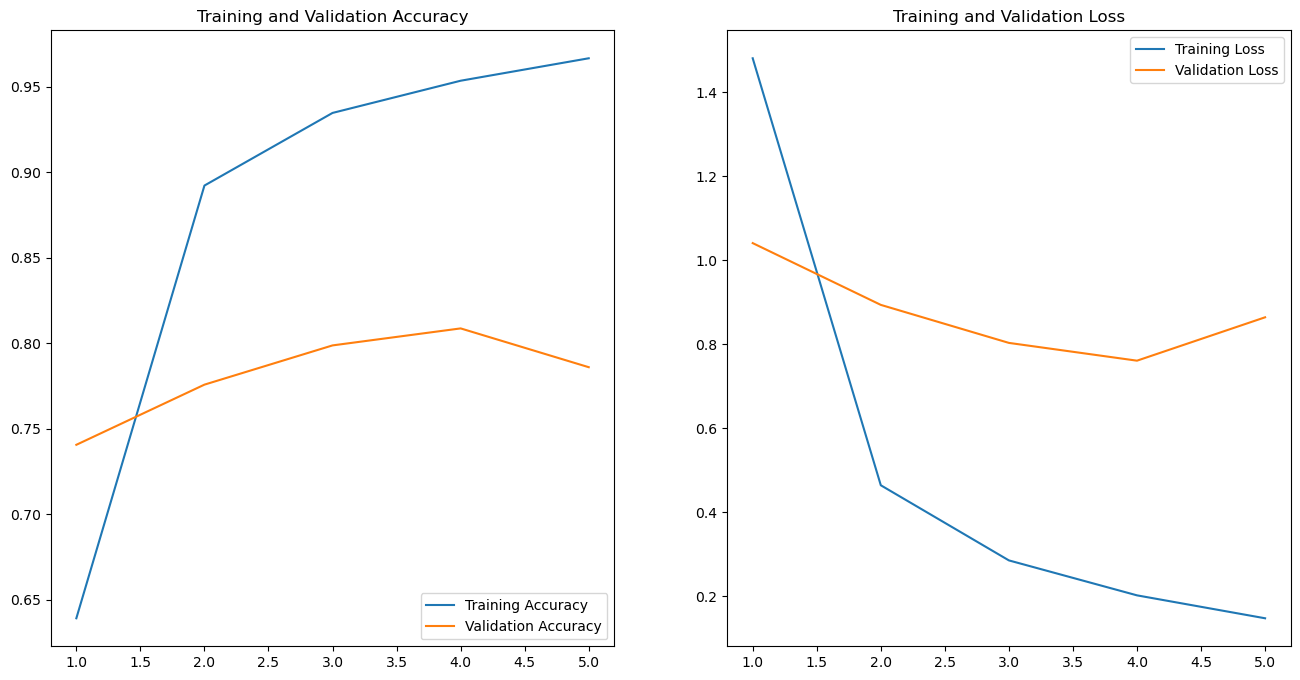

In [20]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

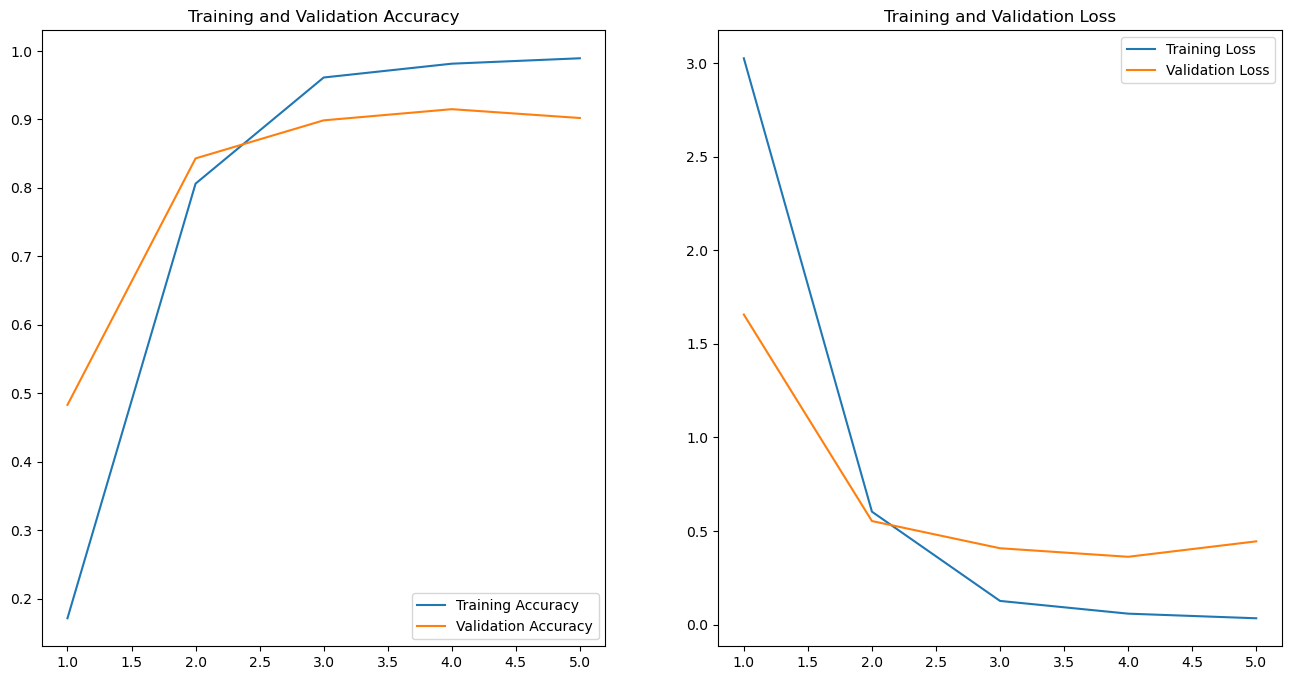

In [21]:
accuracy2 = history2.history['accuracy']
val_accuracy2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy2, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss2, label='Training Loss')
plt.plot(epochs_range, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

학습 데이터는 물론이고 Validation 데이터에서도 성능이 괜찮게 나오는 것으로 보입니다.

테스트 데이터에서는 성능이 어떻게 나오는지 확인해봅니다.

In [22]:
test_loss, test_accuracy = model.evaluate(test_set)
print(f'테스트 정확도: {test_accuracy * 100:.3f}%')

 3/50 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.8038 - loss: 0.8292

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.8204 - loss: 0.7851
테스트 정확도: 82.138%


In [23]:
test_loss, test_accuracy = model2.evaluate(test_set)
print(f'테스트 정확도: {test_accuracy * 100:.3f}%')

50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 291ms/step - accuracy: 0.9153 - loss: 0.4259
테스트 정확도: 91.504%


굉장히 간단한 모델임에도 80%가 넘는 높은 테스트 성능이 나올 것입니다!

모델이 간단한 만큼 모델을 조금 더 복잡하게 만들면 테스트 성능이 오를 것 같고, 또한 epoch 수 또한 5 밖에 지정하지 않아서 이를 늘리면 또 오를 것 같습니다. 이 부분은 제출 사항으로 남겨두겠습니다.

그러면 다음으로 실제 이미지를 보면서 실제 라벨과 예측 값이 잘 일치하는지 몇개를 샘플로 확인해보겠습니다.

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


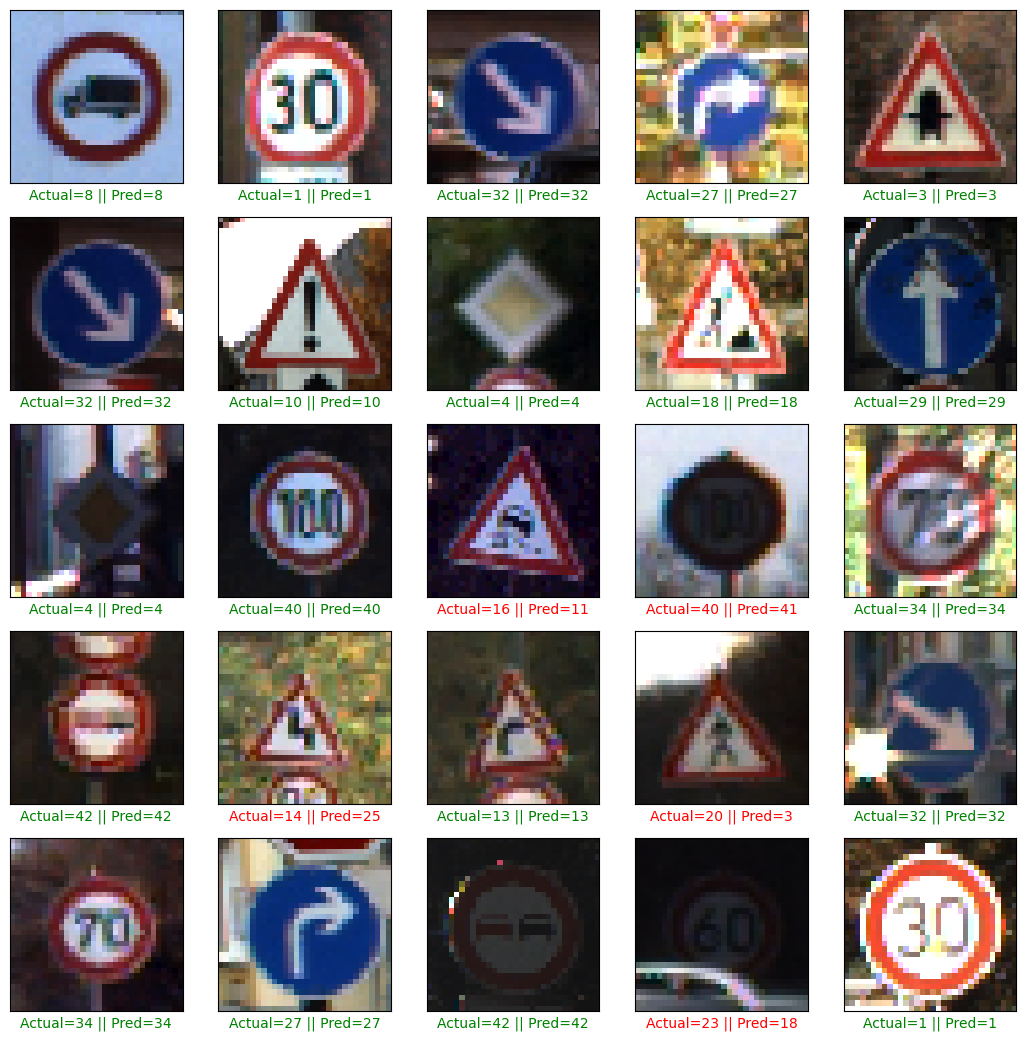

In [24]:
num_sample = 25

test_pred = np.argmax(model.predict(test_set), axis=-1)[:num_sample]
X_test_sample = test_set[0][0][:num_sample, :, :]
y_test_sample = np.argmax(test_set[0][1][:num_sample, :], axis=-1)

plt.figure(figsize=(13, 13))
for i in range(num_sample):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    prediction = test_pred[i]
    actual = y_test_sample[i]
    color = 'g'
    if prediction != actual:
        color = 'r'
    
    plt.xlabel(f'Actual={actual} || Pred={prediction}', color=color)
    plt.imshow(tf.keras.utils.array_to_img(X_test_sample[i]))

plt.show()

In [25]:
tmp_pred = model2.predict(test_set)

50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 292ms/step


In [26]:
for i in range(10):
    print(np.argmax(tmp_pred[i]))

8
1
32
27
3
32
10
4
18
29


50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step


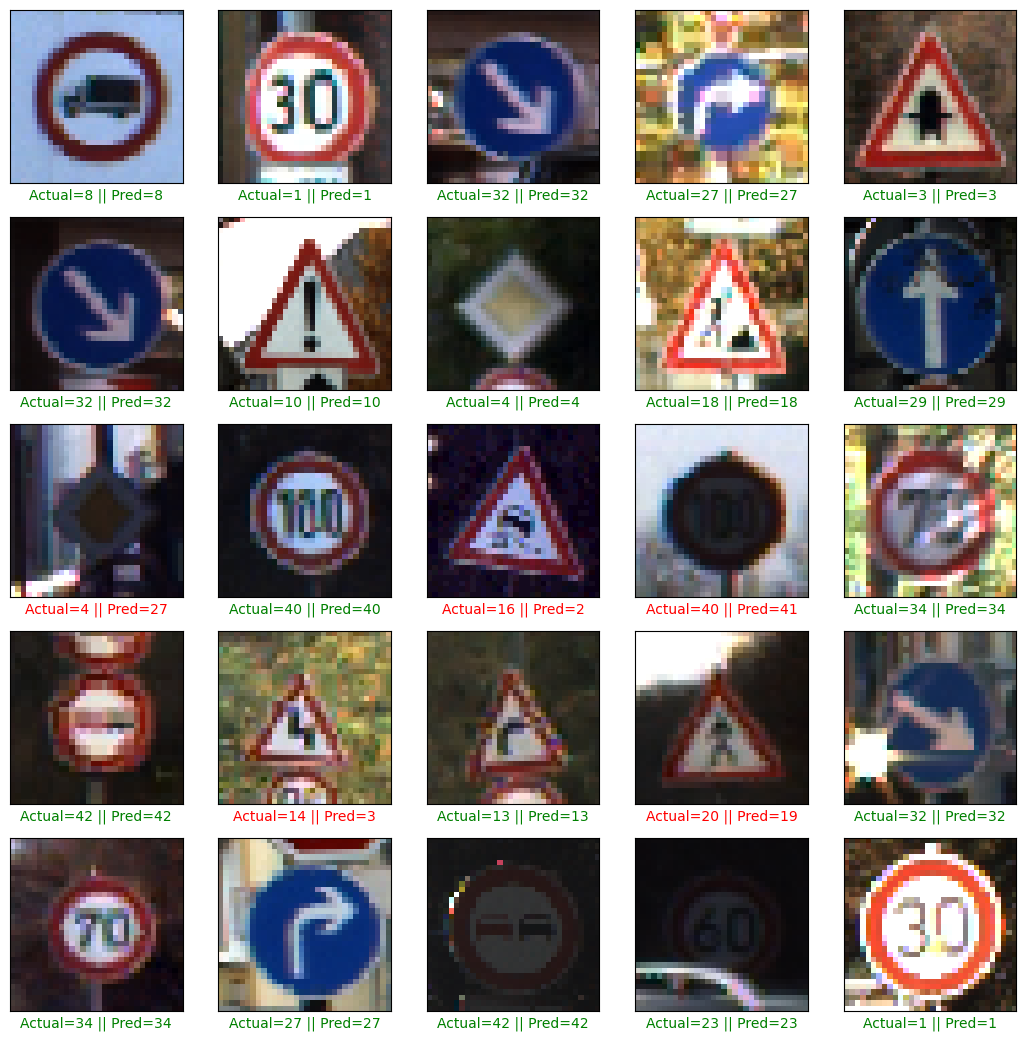

In [27]:
num_sample = 25

test_pred = np.argmax(model2.predict(test_set), axis=-1)[:num_sample]
X_test_sample = test_set[0][0][:num_sample, :, :]
y_test_sample = np.argmax(test_set[0][1][:num_sample, :], axis=-1)

plt.figure(figsize=(13, 13))
for i in range(num_sample):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    prediction = test_pred[i]
    actual = y_test_sample[i]
    color = 'g'
    if prediction != actual:
        color = 'r'
    
    plt.xlabel(f'Actual={actual} || Pred={prediction}', color=color)
    plt.imshow(tf.keras.utils.array_to_img(X_test_sample[i]))

plt.show()

## 제출

앞서 RoI 내용을 확인할 때 이 정보를 제출시에 사용할 것이라고 언급했었습니다.

구체적으로 아래와 같은 과정을 진행할 것입니다.

1. 각 이미지마다 RoI 영역을 자른 다음에 고정된 크기로 이미지 크기를 변환합니다.
2. 프로젝트에서 사용한 모델보다 좀더 나은 새로운 모델을 만듭니다.
3. RoI 영역으로 잘린 데이터로 모델을 학습합니다.
4. `submission_test.csv` 파일에 지정된 테스트 이미지들을 불러와서 각 이미지의 클래스를 예측합니다.
5. 예측한 클래스를 형식에 맞게 CSV 파일로 만들고 제출합니다.

여기서 1번 사항을 수행하려면 프로젝트에서 사용한 `ImageDataGenerator`로는 어려움이 존재합니다. 따라서 아래 `build_roi_cropped_dataset`이라는 이름으로 RoI 영역을 잘라서 데이터셋을 구성하는 함수를 제공할 것입니다.

대신 이 함수의 모든 구현을 제공하지는 않고, 아래 코드는 [Pillow 라이브러리의 `Image` 클래스의 API 문서](https://pillow.readthedocs.io/en/stable/reference/Image.html)를 참조하여 직접 채워야 합니다. 채워야 할 기능은 이미지를 특정 영역으로 자르는 것과, 이미지 크기를 변환하는 부분입니다.

Width                  53
Height                 54
Roi.X1                  6
Roi.Y1                  5
Roi.X2                 48
Roi.Y2                 49
ClassId                16
Path       Test/00000.png
Name: 0, dtype: object


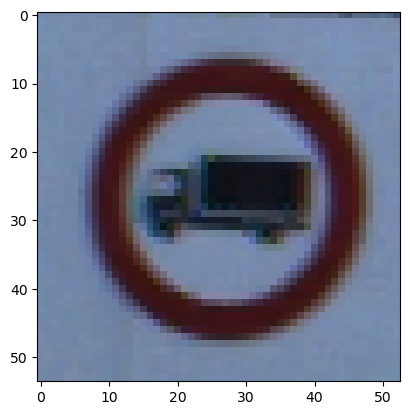

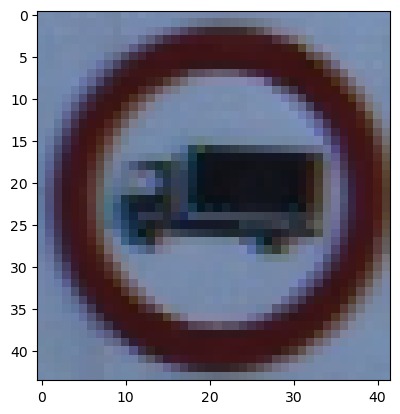

In [28]:
import matplotlib.pyplot as plt

cur_metadata = test_metadata.iloc[0, :]
print(cur_metadata)
img = Image.open(os.path.join(root_dir, cur_metadata['Path']))

plt.imshow(img)
plt.show()

roi_img = img.crop((cur_metadata['Roi.X1'], cur_metadata['Roi.Y1'], cur_metadata['Roi.X2'], cur_metadata['Roi.Y2']))
plt.imshow(roi_img)
plt.show()

In [1]:
# return_y는 정답 데이터를 가져올 수 있을 때는 True로 설정하고 아니면 False로 설정합니다.
# 제출용 데이터는 정답 데이터를 가져올 수없으니 False로 바꾸면 됩니다.
def build_roi_cropped_dataset(metadata, return_y=True):
    X_roi = []
    y_roi = []
    for i in tqdm(range(metadata.shape[0])):
        cur_metadata = metadata.iloc[i, :]
        img = Image.open(os.path.join(root_dir, cur_metadata['Path']))

        # TODO: 이미지를 RoI 영역에 지정한 대로 자릅니다.
        roi_img = img.crop((cur_metadata['Roi.X1'], cur_metadata['Roi.Y1'], cur_metadata['Roi.X2'], cur_metadata['Roi.Y2']))
        
        # TODO: 이미지를 'img_height'과 'img_width' 크기로 바꿉니다.
        roi_img = img.resize(img_height, img_width)

        roi_img_np = np.array(roi_img)
        roi_img_np_norm = roi_img_np / 255.

        X_roi.append(roi_img_np_norm)

        if return_y:
            y_roi.append(int(cur_metadata['ClassId']))

    X_roi = np.stack(X_roi, axis=0)

    if return_y:
        y_roi = np.array(y_roi).astype(int)
    else:
        y_roi = None
        
    return X_roi, y_roi

# ResNet

In [61]:
class ResidualBlock(Model):
    def __init__(self, num_kernels, kernel_size, n):
        super(ResidualBlock, self).__init__()

        # TODO: [지시사항 1번] 2개의 Conv2D Layer를 지시사항에 따라 추가하세요.
        self.conv = tf.keras.layers.Conv2D(filters=num_kernels, kernel_size=kernel_size, padding='same', activation=tf.nn.relu)
        
        self.relu = tf.keras.layers.Activation("relu")
        
        # TODO: [지시사항 1번] Add Layer를 추가하세요.
        self.add = tf.keras.layers.Add() # F(x)+x에서 +역할
        
        self.n = n

    def call(self, input_tensor):
        x = self.conv(input_tensor)
        
        for _ in range(self.n-1):
            x = self.conv(x)
        
        x = self.add([x, input_tensor]) # 두 값을 더하는 과정 -> num_kernels를 다르게 부여할 시 입력과 결과가 맞지 않아 오류 발생..
        x = self.relu(x)
        
        return x
        
def build_resnet(input_shape, num_classes):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", input_shape= (img_height, img_width, 3)))
    model.add(tf.keras.layers.MaxPool2D(2))

    model.add(ResidualBlock(32, (3, 3), 2))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=1, padding='same', activation=None))
    model.add(ResidualBlock(64, (3, 3), 3))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=1, padding='same', activation=None))
    model.add(ResidualBlock(128, (3, 3), 3))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=1, padding='same', activation=None))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(43, activation="softmax"))
    
    return model

model3 = build_resnet((32, 32, 3), 43)
model3.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_85 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_30               │ (None, 16, 16, 32)     │         9,248 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 16, 16, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_31               │ (None, 16, 16, 64)     │        36,928 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 16, 16, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_32               │ (None, 16, 16, 128)    │       147,584 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 16, 16, 256)    │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 43)             │     2,818,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,056,203 (11.66 MB)

 Trainable params: 3,056,203 (11.66 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model3.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [64]:
history3 = model3.fit(train_set, epochs=num_epochs, validation_data=valid_set)

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 92s 743ms/step - accuracy: 0.8010 - loss: 0.6898 - val_accuracy: 0.8677 - val_loss: 0.4696
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 96s 779ms/step - accuracy: 0.9698 - loss: 0.1076 - val_accuracy: 0.8630 - val_loss: 0.5152
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 94s 760ms/step - accuracy: 0.9846 - loss: 0.0512 - val_accuracy: 0.8717 - val_loss: 0.6201
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 91s 739ms/step - accuracy: 0.9885 - loss: 0.0358 - val_accuracy: 0.9091 - val_loss: 0.4241
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 106s 857ms/step - accuracy: 0.9922 - loss: 0.0235 - val_accuracy: 0.9026 - val_loss: 0.4242


In [65]:
test_loss, test_accuracy = model3.evaluate(test_set)
print(f'테스트 정확도: {test_accuracy * 100:.3f}%')

50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 233ms/step - accuracy: 0.9114 - loss: 0.4358
테스트 정확도: 91.013%


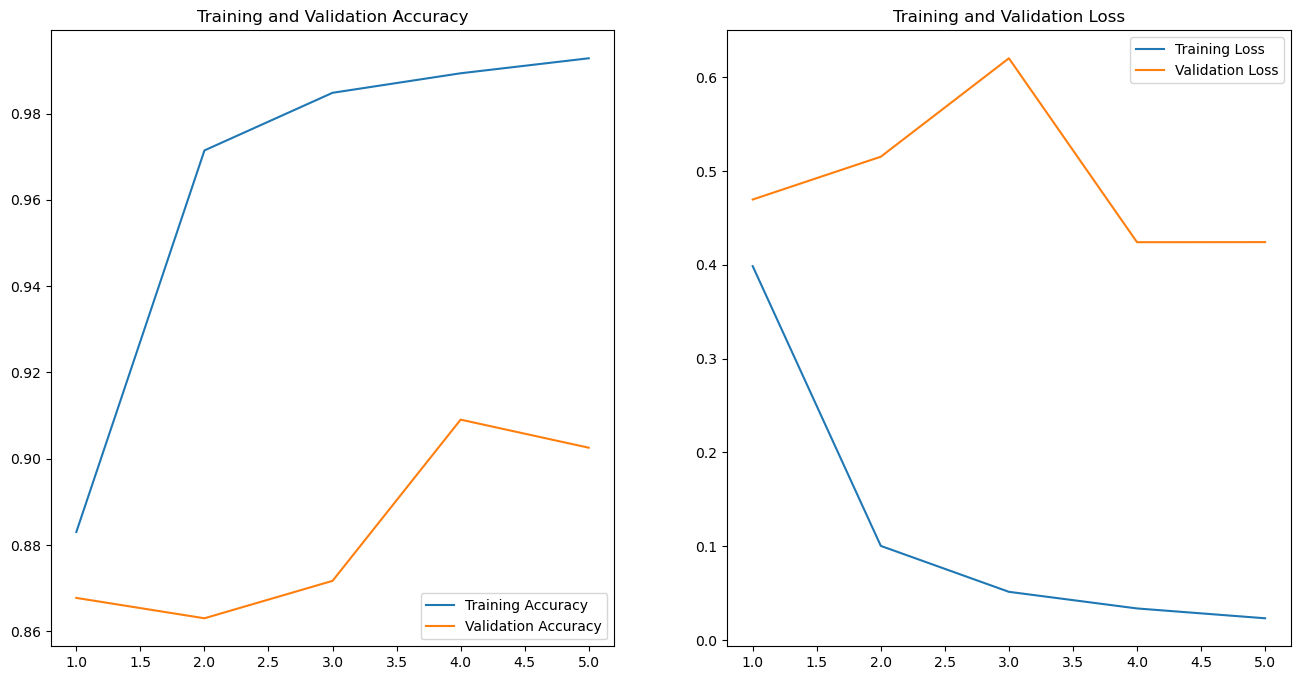

In [66]:
accuracy3 = history3.history['accuracy']
val_accuracy3 = history3.history['val_accuracy']

loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy3, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss3, label='Training Loss')
plt.plot(epochs_range, val_loss3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()